# [Bacterial Colony Growth](@id Bacteries)

In [1]:
using AgentBasedModels

using Distributions
using GLMakie
import GLMakie: GeometryBasics
GLMakie.inline!(true)

In [2]:
function plotRod2D!(ax, x, y, r, l, angle, color)

    pos = [x,y]
    dir = [cos(angle), sin(angle)]
    extreme1 = GeometryBasics.Point((pos+l/2*dir)...,0.)
    extreme2 = GeometryBasics.Point((pos-l/2*dir)...,0.)

    ci = GeometryBasics.Cylinder(extreme1,extreme2,Float64(r))
    b1 = GeometryBasics.Sphere(extreme1,Float64(r))
    b2 = GeometryBasics.Sphere(extreme2,Float64(r))    

    GLMakie.mesh!(ax,ci,color=color)
    GLMakie.mesh!(ax,b1,color=color)
    GLMakie.mesh!(ax,b2,color=color)

end

function plotRods2D!(ax, x, y, r, l, angle, color)

    for i in 1:length(x)
        plotRod2D!(ax, x[i], y[i], r[i], l[i], angle[i], color[i])
    end

end

plotRods2D! (generic function with 1 method)

In [3]:
model = Agent(2,
    baseModelInit = [Models.rod2D],

    globalFloat = [:growth,:lMax],

    updateVariable = quote
        d(l) = dt( growth )
    end,

    updateLocal = quote #Bound cells
        #Add division
        if l > lMax
            addAgent(
                    x=(l+d)/4*cos(theta)+x,
                    y=(l+d)/4*sin(theta)+y,
                    l=(l-d)/2,
                    theta = theta+Uniform(-.1,.1),
                    ω = 0
                    )
            addAgent(
                    x=-(l+d)/4*cos(theta)+x,
                    y=-(l+d)/4*sin(theta)+y,
                    l=(l-d)/2,
                    theta = theta+Uniform(-.1,.1),
                    ω = 0,
                    )
            removeAgent()
        end
    end,

    integrator=:Heun

);

In [9]:
com = Community(model,N=[1],dt=[0.1]);

com.kn = .0001*1000
com.γn = 1.
com.γt = 1.
com.μcc = 0.1
com.μcw = 0.8
com.β = .5
com.βω = .1
com.growth = 0.001
com.lMax = 3

com.m = 1.
com.d = 1.
com.l = 2.99;

com.x = 0
com.y = 0
com.theta = 0

com.simBox = [-20 20;-20 20.];

In [10]:
evolve!(com,steps=100000,saveEach=1000,preallocateAgents=100)

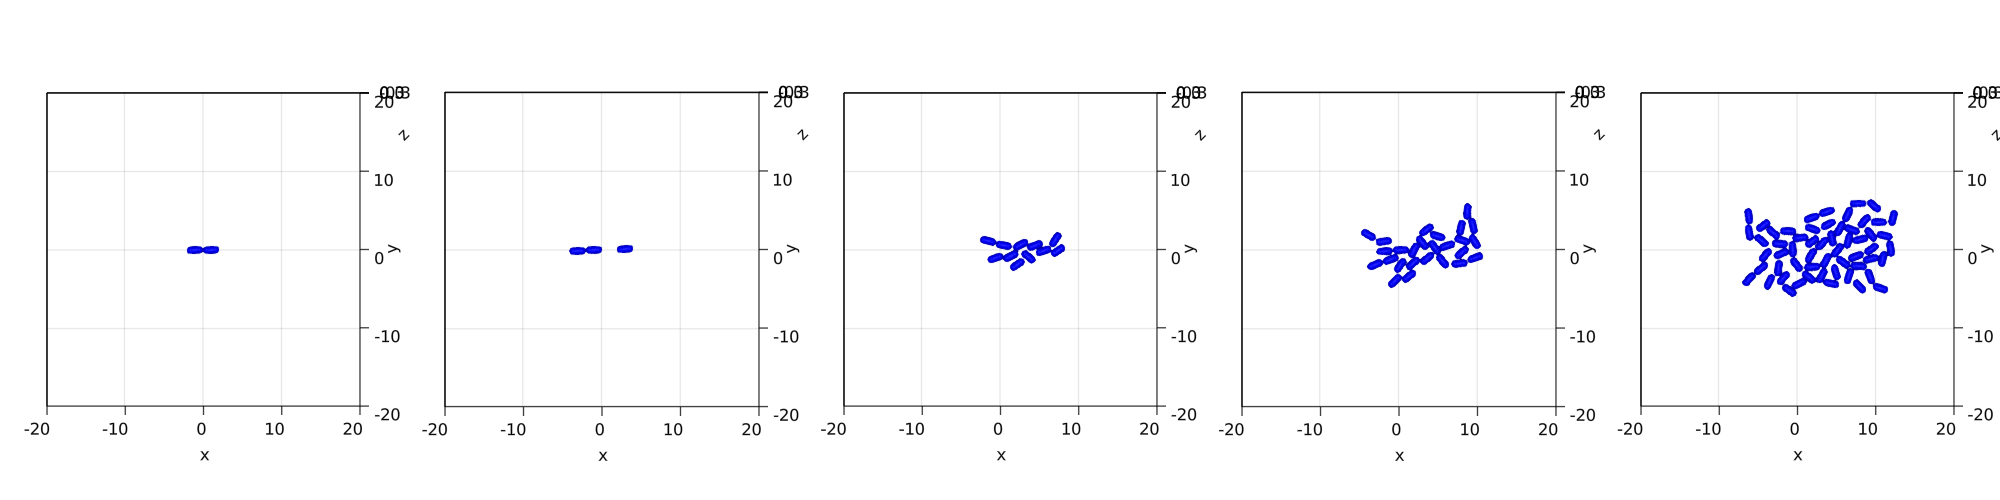

In [11]:
d = getParameter(com,[:x,:y,:d,:l,:theta])

fig = Figure(resolution=(2000,500))

for (i,t) in enumerate(1:round(Int64,length(com)/5):length(com))

    ax = Axis3(fig[1,i],elevation=.5*π,azimuth=1.5*π,viewmode=:fitzoom,aspect = :data)

    plotRods2D!(ax,d[:x][t],d[:y][t],d[:d][t]./2,d[:l][t],d[:theta][t],[:blue for i in 1:length(d[:x][t])])

    xlims!(ax,-20,20)
    ylims!(ax,-20,20)
    
end

fig

In [12]:
d = getParameter(com,[:N,:x,:y,:d,:l,:theta])
colorMap = Dict(1=>:blue,2=>:orange,3=>:green)
for (i,time) in enumerate(1:length(com))
    fig = Figure(resolution=(2000,2000))
    ax = Axis(fig[1,1],title=string("N: ",d[:N][time][1]),titlesize=70)

    plotRods2D!(ax,d[:x][time],d[:y][time],d[:d][time]./2,d[:l][time],d[:theta][time],[:blue for i in 1:length(d[:x][time])])

    xlims!(ax,(com.simBox[1,:].+[-1,1])...)
    ylims!(ax,(com.simBox[2,:].+[-1,1])...)

    ind = "000$i"
    save("video/Bacteries$(ind[end-2:end]).jpeg",fig)
end